In [1]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.optim import Adam
from data_loading import process_text_df, NewsText, tensorize_sentences, collate_fn
from tqdm import tqdm as pbar
from models import NewsNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import matplotlib.pyplot as plt
import tqdm
stopwords = stopwords.words()
words = words.words() 
wordnet = wordnet.words()

In [2]:
import pandas as pd
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords, words, wordnet
from nltk.lm import Vocabulary
import numpy as np
import torch
from torch import nn
import concurrent.futures
from torch.utils.data import Dataset, DataLoader
from nltk.stem.snowball import EnglishStemmer
from torch import tensor
stopwords = stopwords.words()
words = words.words() 
wordnet = wordnet.words()

class process_text_df():
    
    def __init__(self, df, text_cols):
        self.df = df.copy()
        self.text_cols = text_cols
        self.stemmer = EnglishStemmer()
        
    def word_only(self, l):
        nopunkt = lambda w: ''.join([char for char in w if char.isalnum()])
        l = [nopunkt(w) for w in l]
        return l

    def clean_text_col(self, text_col):
        text_col = text_col.apply(lambda text: WhitespaceTokenizer().tokenize(text))
        text_col = text_col.apply(lambda sent: [word.lower() for word in sent])
        text_col = text_col.apply(lambda sent: [word for word in sent if word not in stopwords])
        text_col = text_col.apply(lambda sent: self.word_only(sent))
        text_col = text_col.apply(lambda sent: [self.stemmer.stem(word) for word in sent])
        return text_col

    def chunk_arr(self, arr, n_partitions=8):
        size = len(arr) // n_partitions
        out = [arr[i * size:(i + 1) * size] for i in range(n_partitions + 1)]
        return out

    def clean_tokenize(self, text_col):
        with concurrent.futures.ProcessPoolExecutor(4) as executor:
            chunks = self.chunk_arr(self.df[text_col], 4)
            results = executor.map(self.clean_text_col, chunks)
            out = [result for result in results]
        out = pd.concat(out)
        return out

    def process_text_col(self):
        for text_col in self.text_cols:
            self.df[text_col] = self.clean_tokenize(text_col)
            
    def build_vocab(self):
        out = []
        for col in self.text_cols:
            col_ = self.df[col]
            extend = [w for sent in col_ for w in sent]
            out.extend(extend)
        out = list(Vocabulary(out, unk_cutoff=100))
        out = {out[i]:len(out) - (i + 1) for i in range(len(out))}
        self.vocab = out
    
    def tokenize_sentences(self):
        self.build_vocab()
        for text_col in self.text_cols:
            self.df[text_col] =\
            self.df[text_col].apply(lambda sent: [word if word in self.vocab else '<UNK>' for word in sent])
            self.df[text_col] =\
            self.df[text_col].apply(lambda sent: [self.vocab[word] for word in sent])
        
def tensorize_sentences(text_series, labels):
    sentences, labels = [torch.tensor(text) for text in text_series], \
                        tensor(labels.apply(lambda l: 1 if l == 'true' else 0))
    return sentences, labels

class NewsText(Dataset):

    def __init__(self, news_text_list, labels):
        self.news_text_list = news_text_list
        self.labels = labels

    def __len__(self):
        assert(len(self.news_text_list) == len(self.labels))
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.news_text_list[idx], self.labels[idx]
        return sample

def pad_sent(sents, max_seq_len):
    max_seq_len = min(100, max_seq_len)
    out = []
    for i in range(len(sents)):
        sent = sents[i]
        append_tensor = tensor([sent[j] if j < len(sent) else 0 for j in range(max_seq_len)]).unsqueeze(0)
        out.append(append_tensor)
    out = torch.cat(out)
    return out
    

def collate_fn(sample):

    labels = tensor([s[1] for s in sample])
    sents = [s[0] for s in sample]
    max_seq_len = max([sent.shape[0] for sent in sents])
    sents = pad_sent(sents, max_seq_len)
    return sents, labels



In [3]:
fake, true = pd.read_csv('Fake.csv'), pd.read_csv('True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)

In [4]:
p1 = process_text_df(news, ['title', 'text'])

In [5]:
%%time
p1.process_text_col()

CPU times: user 2.96 s, sys: 1.34 s, total: 4.3 s
Wall time: 4min 28s


In [6]:
p1.df

,title,text,subject,date,label
0,"[poland, alloc, addit, 55, bllion, defens, 203...","[warsaw, reuter, , poland, alloc, addit, 200, ...",worldnews,"August 23, 2017",true
1,"[michell, obama, dish, dirt, barack, he, bare,...","[thank, intel, mooch, outsid, ambit, fundament...",left-news,"Jan 27, 2016",fake
2,"[new, russian, envoy, describ, warm, meet, tru...","[moscow, reuter, , russia, newli, instal, amba...",politicsNews,"September 8, 2017",true
3,"[cambodia, detain, opposit, leader, deni, trea...","[phnom, penh, reuter, , cambodia, detain, oppo...",worldnews,"October 2, 2017",true
4,"[kurdish, leader, barzani, condemn, iraqi, par...","[reuter, , kurdish, presid, massoud, barzani, ...",worldnews,"September 14, 2017",true
...,...,...,...,...,...
44893,"[food, stamp, rap, song, ebt, card, mani, way,...","[month, cost, fed, pay, food, stamp, sicken, t...",Government News,"Dec 22, 2015",fake
44894,"[nevertrump, gop, intellig, expert, launch, in...","[nevertrump, faction, gop, long, independ, con...",News,"August 8, 2016",fake
44895,"[taiwan, boost, defens, spend, us, concern, po...","[taipei, reuter, , taiwan, increas, futur, def...",worldnews,"October 30, 2017",true
44896,"[islam, state, flag, fli, bosnia, pm]","[sarajevo, reuter, , islam, state, flag, fli, ...",worldnews,"September 12, 2017",true


In [7]:
p1.tokenize_sentences()

In [8]:
l, labs = tensorize_sentences(p1.df.text.apply(lambda sent: sent[:], p1.df.label)

In [9]:
# l, labs = tensorize_sentences(p1.df.text.apply(lambda sent: sent[:100]), p1.df.label)

In [10]:
from torch import nn
from collections import OrderedDict

class LinearBlock(nn.Module):
    
    def __init__(self, layer_sequence, add_relu=False):
        super(LinearBlock, self).__init__()
        num_layers = len(layer_sequence) - 1
        layers = []
        names = []
        for i in range(num_layers):
            layers.append(nn.Linear(in_features=layer_sequence[i],
                                    out_features=layer_sequence[i + 1],
                                    bias=False)
                         )
            names.append(f'fc{i + 1}')
                
            if add_relu and i != num_layers - 1:
                layers.append(nn.ReLU())
                names.append(f'relu{i + 1}')
        
        self.module_dict = OrderedDict(zip(names, layers))
        self.block = nn.Sequential(self.module_dict)
        
    def forward(self, x):
        out = self.block(x)
        
        return out

class NewsNet(nn.Module):
    
    def __init__(self, vocab, hidden_size=10, embedding_dim=16, num_layers=2, pretrained_embeddings=None):
        super(NewsNet, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.word_embeddings = nn.Embedding(num_embeddings=len(vocab), embedding_dim=self.embedding_dim)
        if pretrained_embeddings is not None:
            self.word_embeddings.weight.data.copy_(pretrained_embeddings.weight.data)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            bias=False, 
                            hidden_size=self.hidden_size, 
                            batch_first=True,
                            num_layers=self.num_layers)
        self.linear_block = LinearBlock([self.hidden_size, self.hidden_size * 2, self.hidden_size, 1])
        
    def forward(self, s):
        
        out = self.word_embeddings(s)
        sequence_out, (h, c) = self.lstm(out)
        out = h[-1]
        out = self.linear_block(out)
        
        return out

In [11]:
net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=5e-6)
idx = len(l) // 4

l_tr, labs_tr = l[:-2 * idx], labs[: -2 * idx]
l_val, labs_val = l[-2 * idx:-idx], labs[-2 * idx:-idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
l_tr, l_val, labs_tr, labs_val = l[:idx], l[idx:], labs[:idx], labs[idx:]
tr_set = NewsText(l_tr, labs_tr)
val_set = NewsText(l_val, labs_val)
_, val_set = enumerate(DataLoader(val_set, batch_size=len(val_set), collate_fn=collate_fn)).__next__()
val_features, val_labels = val_set
val_labels = val_labels.unsqueeze(-1).float()
loader = DataLoader(tr_set, batch_size=4, collate_fn=collate_fn)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 50
for i in range(epochs):
    print(f'Epoch {i + 1}')
    for sents, labels in pbar(loader):
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
        
    loss_list.append(loss.item())

  1%|          | 20/2806 [00:00<00:14, 196.02it/s]

Epoch 1


  1%|          | 21/2806 [00:00<00:13, 209.27it/s]

Epoch 2


  1%|          | 22/2806 [00:00<00:13, 211.39it/s]

Epoch 3


  1%|          | 21/2806 [00:00<00:13, 202.59it/s]

Epoch 4


  1%|          | 21/2806 [00:00<00:13, 202.05it/s]

Epoch 5


  1%|          | 22/2806 [00:00<00:13, 212.75it/s]

Epoch 6


  1%|          | 22/2806 [00:00<00:13, 212.70it/s]

Epoch 7


  1%|          | 20/2806 [00:00<00:14, 194.10it/s]

Epoch 8


  1%|          | 22/2806 [00:00<00:13, 213.67it/s]

Epoch 9


  1%|          | 22/2806 [00:00<00:13, 212.60it/s]

Epoch 10


  1%|          | 22/2806 [00:00<00:13, 212.15it/s]

Epoch 11


  1%|          | 19/2806 [00:00<00:14, 186.81it/s]

Epoch 12


  1%|          | 22/2806 [00:00<00:13, 211.23it/s]

Epoch 13


  1%|          | 22/2806 [00:00<00:13, 214.12it/s]

Epoch 14


  1%|          | 22/2806 [00:00<00:13, 212.39it/s]

Epoch 15


  1%|          | 22/2806 [00:00<00:13, 213.80it/s]

Epoch 16


  1%|          | 22/2806 [00:00<00:12, 215.58it/s]

Epoch 17


  1%|          | 22/2806 [00:00<00:13, 211.75it/s]

Epoch 18


  1%|          | 22/2806 [00:00<00:13, 209.75it/s]

Epoch 19


  1%|          | 22/2806 [00:00<00:13, 212.22it/s]

Epoch 20


  1%|          | 22/2806 [00:00<00:13, 212.85it/s]

Epoch 21


  1%|          | 22/2806 [00:00<00:13, 211.32it/s]

Epoch 22


  1%|          | 21/2806 [00:00<00:13, 208.76it/s]

Epoch 23


  1%|          | 21/2806 [00:00<00:13, 206.74it/s]

Epoch 24


  1%|          | 21/2806 [00:00<00:13, 206.88it/s]

Epoch 25


  1%|          | 21/2806 [00:00<00:13, 208.34it/s]

Epoch 26


  1%|▏         | 42/2806 [00:00<00:13, 206.53it/s]

Epoch 27


  1%|          | 22/2806 [00:00<00:13, 210.63it/s]

Epoch 28


  1%|          | 20/2806 [00:00<00:14, 194.91it/s]

Epoch 29


  1%|          | 21/2806 [00:00<00:13, 206.57it/s]

Epoch 30


  2%|▏         | 43/2806 [00:00<00:13, 209.39it/s]

Epoch 31


  1%|          | 22/2806 [00:00<00:13, 209.89it/s]

Epoch 32


  1%|          | 22/2806 [00:00<00:13, 210.11it/s]

Epoch 33


  1%|▏         | 42/2806 [00:00<00:13, 206.95it/s]

Epoch 34


  1%|▏         | 42/2806 [00:00<00:13, 205.78it/s]

Epoch 35


  1%|▏         | 42/2806 [00:00<00:13, 207.54it/s]

Epoch 36


  1%|▏         | 42/2806 [00:00<00:13, 206.71it/s]

Epoch 37


  1%|▏         | 42/2806 [00:00<00:13, 206.01it/s]

Epoch 38


  1%|▏         | 42/2806 [00:00<00:13, 208.31it/s]

Epoch 39


  1%|▏         | 42/2806 [00:00<00:13, 207.40it/s]

Epoch 40


  2%|▏         | 44/2806 [00:00<00:13, 210.65it/s]

Epoch 41


  1%|▏         | 42/2806 [00:00<00:13, 207.36it/s]

Epoch 42


  1%|          | 21/2806 [00:00<00:13, 208.76it/s]

Epoch 43


  1%|▏         | 42/2806 [00:00<00:13, 208.14it/s]

Epoch 44


  1%|▏         | 42/2806 [00:00<00:13, 208.38it/s]

Epoch 45


  2%|▏         | 43/2806 [00:00<00:13, 209.17it/s]

Epoch 46


  1%|          | 21/2806 [00:00<00:13, 202.02it/s]

Epoch 47


  1%|          | 20/2806 [00:00<00:14, 196.36it/s]

Epoch 48


  1%|          | 21/2806 [00:00<00:13, 202.24it/s]

Epoch 49


  1%|          | 21/2806 [00:00<00:13, 205.57it/s]

Epoch 50


100%|██████████| 2806/2806 [00:13<00:00, 204.14it/s]


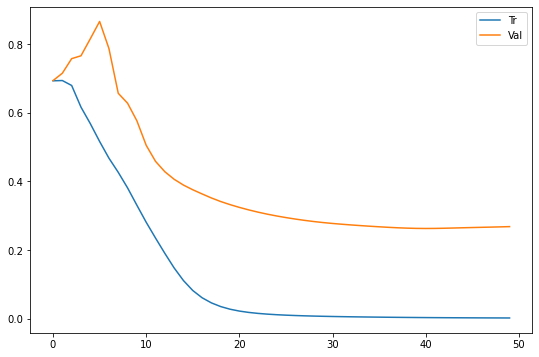

In [12]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

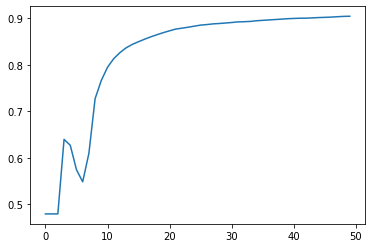

In [13]:
pd.Series(accuracy_list).plot()

In [14]:
tst_set = NewsText(l_tst, labs_tst)
_, tst_set = enumerate(DataLoader(tst_set, batch_size=len(tst_set), collate_fn=collate_fn)).__next__()
tst_features, tst_labels = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [15]:
with torch.no_grad():
    tst_out = net(tst_features)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [16]:
accuracy_tst

0.897719144821167

In [23]:
pretrained_embeddings = net.word_embeddings
net2 = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2, pretrained_embeddings=pretrained_embeddings)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net2.parameters(), lr=1e-4, weight_decay=5e-6)
idx = len(l) // 4

l_tr, labs_tr = l[:-2 * idx], labs[: -2 * idx]
l_val, labs_val = l[-2 * idx:-idx], labs[-2 * idx:-idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
l_tr, l_val, labs_tr, labs_val = l[:idx], l[idx:], labs[:idx], labs[idx:]
tr_set = NewsText(l_tr, labs_tr)
val_set = NewsText(l_val, labs_val)
_, val_set = enumerate(DataLoader(val_set, batch_size=len(val_set), collate_fn=collate_fn)).__next__()
val_features, val_labels = val_set
val_labels = val_labels.unsqueeze(-1).float()
loader = DataLoader(tr_set, batch_size=4, collate_fn=collate_fn)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 40
for i in range(epochs):
    print(f'Epoch {i + 1}')
    for sents, labels in pbar(loader):
        net2.train()
        labels = labels.float().unsqueeze(-1)
        out = net2(sents)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net2.eval()
    with torch.no_grad():
        val_out = net2(val_features)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
        
    loss_list.append(loss.item())

  1%|▏         | 41/2806 [00:00<00:14, 197.00it/s]

Epoch 1


  1%|          | 21/2806 [00:00<00:13, 204.99it/s]

Epoch 2


  1%|          | 20/2806 [00:00<00:14, 197.26it/s]

Epoch 3


  1%|          | 20/2806 [00:00<00:14, 192.74it/s]

Epoch 4


  1%|          | 18/2806 [00:00<00:16, 171.02it/s]

Epoch 5


  1%|          | 21/2806 [00:00<00:13, 208.14it/s]

Epoch 6


  1%|          | 22/2806 [00:00<00:13, 212.31it/s]

Epoch 7


  1%|          | 22/2806 [00:00<00:13, 212.24it/s]

Epoch 8


  1%|          | 22/2806 [00:00<00:12, 214.58it/s]

Epoch 9


  1%|          | 21/2806 [00:00<00:13, 209.24it/s]

Epoch 10


  1%|          | 22/2806 [00:00<00:13, 210.22it/s]

Epoch 11


  1%|          | 22/2806 [00:00<00:13, 212.57it/s]

Epoch 12


  1%|          | 20/2806 [00:00<00:14, 196.50it/s]

Epoch 13


  1%|          | 21/2806 [00:00<00:13, 209.32it/s]

Epoch 14


  1%|          | 20/2806 [00:00<00:14, 195.95it/s]

Epoch 15


  1%|          | 21/2806 [00:00<00:13, 204.45it/s]

Epoch 16


  1%|          | 22/2806 [00:00<00:12, 214.16it/s]

Epoch 17


  1%|          | 21/2806 [00:00<00:14, 195.06it/s]

Epoch 18


  1%|          | 20/2806 [00:00<00:14, 191.74it/s]

Epoch 19


  1%|          | 19/2806 [00:00<00:14, 189.02it/s]

Epoch 20


  1%|          | 17/2806 [00:00<00:16, 168.91it/s]

Epoch 21


  1%|          | 20/2806 [00:00<00:14, 194.52it/s]

Epoch 22


  1%|          | 21/2806 [00:00<00:13, 208.07it/s]

Epoch 23


  1%|          | 20/2806 [00:00<00:14, 190.34it/s]

Epoch 24


  1%|          | 22/2806 [00:00<00:13, 210.51it/s]

Epoch 25


  1%|          | 20/2806 [00:00<00:14, 197.09it/s]

Epoch 26


  1%|          | 20/2806 [00:00<00:14, 193.55it/s]

Epoch 27


  1%|          | 19/2806 [00:00<00:14, 189.01it/s]

Epoch 28


  1%|          | 18/2806 [00:00<00:15, 176.45it/s]

Epoch 29


  1%|          | 19/2806 [00:00<00:14, 188.07it/s]

Epoch 30


  1%|          | 20/2806 [00:00<00:14, 196.58it/s]

Epoch 31


  1%|          | 20/2806 [00:00<00:14, 198.38it/s]

Epoch 32


  1%|          | 19/2806 [00:00<00:14, 189.78it/s]

Epoch 33


  1%|          | 22/2806 [00:00<00:13, 212.82it/s]

Epoch 34


  1%|          | 22/2806 [00:00<00:13, 210.05it/s]

Epoch 35


  1%|          | 22/2806 [00:00<00:13, 211.17it/s]

Epoch 36


  1%|          | 22/2806 [00:00<00:13, 210.66it/s]

Epoch 37


  2%|▏         | 43/2806 [00:00<00:13, 212.30it/s]

Epoch 38


  1%|          | 22/2806 [00:00<00:13, 212.37it/s]

Epoch 39


  1%|          | 22/2806 [00:00<00:13, 210.09it/s]

Epoch 40


100%|██████████| 2806/2806 [00:13<00:00, 201.79it/s]


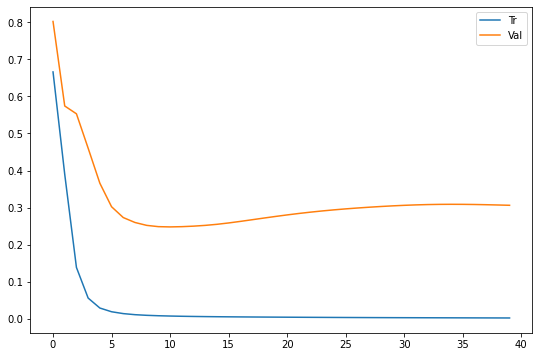

In [24]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

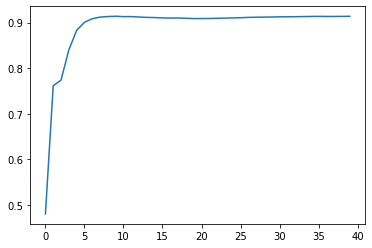

In [25]:
pd.Series(accuracy_list).plot()

In [30]:
val_loss_list

[0.8024015426635742,
 0.574191689491272,
 0.5530876517295837,
 0.4602629840373993,
 0.3656991422176361,
 0.302175909280777,
 0.27294689416885376,
 0.25965043902397156,
 0.2518690526485443,
 0.24840833246707916,
 0.24770767986774445,
 0.24836556613445282,
 0.2497565746307373,
 0.25183776021003723,
 0.2547251880168915,
 0.2583865523338318,
 0.26258912682533264,
 0.2670474648475647,
 0.27153897285461426,
 0.27592208981513977,
 0.28010058403015137,
 0.2840051054954529,
 0.2875882089138031,
 0.2908357083797455,
 0.2937568426132202,
 0.29638198018074036,
 0.29874739050865173,
 0.3008817136287689,
 0.3028077185153961,
 0.30451488494873047,
 0.30597713589668274,
 0.30715814232826233,
 0.3080240786075592,
 0.30855125188827515,
 0.3087382912635803,
 0.3086185157299042,
 0.3082343339920044,
 0.3076380789279938,
 0.3068894147872925,
 0.3060851991176605]

In [26]:
tst_set = NewsText(l_tst, labs_tst)
_, tst_set = enumerate(DataLoader(tst_set, batch_size=len(tst_set), collate_fn=collate_fn)).__next__()
tst_features, tst_labels = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [27]:
with torch.no_grad():
    tst_out = net2(tst_features)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [28]:
accuracy_tst

0.9081432819366455